# Testing

In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 
import numpy as np


### Auxiliary functions for model generation

In [2]:
from tensorflow.keras import layers


def get_UNN_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )

        drop = layers.SpatialDropout2D(0.2)(x)

        x = layers.add([x, residual, drop])  # Add back residual and dropout
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        drop = layers.SpatialDropout2D(0.2)(x)

        x = layers.add([x, residual, drop])  # Add back residual and dropout
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

def get_CNN_model(img_size,number_of_classes):
    model = tf.keras.Sequential([ 
        tf.keras.layers.Conv2D(32,3,input_shape=(img_size[0],img_size[1],1)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(input_shape=(img_size[0],img_size[1],1)),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(number_of_classes,activation='softmax')
    ])
    return model

### Load CNN and UNet models

In [3]:
UNet_path = "../../UNet/emnist.h5"
CNN_path = "../../CNN/CNN.h5"

letter_size = (28,28)
images_size = (160,160)
num_classes = 27

UNet_model = get_UNN_model(images_size, num_classes)
UNet_model.load_weights(UNet_path)

CNN_model = get_CNN_model(letter_size,num_classes)
CNN_model.load_weights(CNN_path)


### Apply UNet on image

Given that the text in the images will be known, the pixels in the image are expected to belong to certain classes (one per letter). 

1/1 [==============================] - 0s 16ms/step


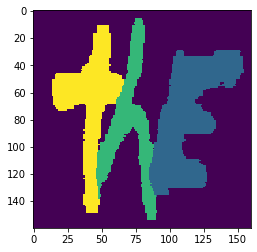

In [7]:
from tensorflow.keras.utils import load_img

testimg_path = "../../UNet/XTest/1.png"

x = np.zeros((1,) + images_size + (3,), dtype="float32")
x[0] = load_img(testimg_path,target_size=images_size)

test_preds = UNet_model.predict(x)

letter_indexes = [0,5,8,20] #Numbers corresponding to background and letters e,h and t

predicted_mask = np.argmax(test_preds[:,:,:,letter_indexes], axis=-1)
plt.imshow(predicted_mask[0,:,:])

In [5]:
#Find the bounding box of letter 1
segmentation = np.where(predicted_mask[0] == 3)
bbox = 0, 0, 0, 0
x_min = int(np.min(segmentation[1]))
x_max = int(np.max(segmentation[1]))
y_min = int(np.min(segmentation[0]))
y_max = int(np.max(segmentation[0]))

print(x_min,x_max,y_min,y_max)

14 66 11 148


**REMEMBER TO TRANSPOSE THE IMAGES BEFORE INPUTTING TO CNN**

In [171]:
from tensorflow.keras.preprocessing import image
from PIL import ImageOps

char_cropped = image.img_to_array(cv2.transpose(x[0]))
char_cropped = char_cropped[x_min:x_max,y_min:y_max, :]
char_cropped = image.array_to_img(char_cropped)

char_resized = ImageOps.grayscale(char_cropped.resize(letter_size))


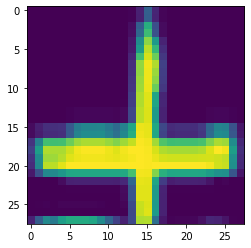

In [172]:

inputImg = (255-image.img_to_array(char_resized))/255.0
input_arr = np.array([inputImg])  # Convert single image to a batch.

plt.imshow(image.array_to_img(inputImg))

In [173]:
predictions = CNN_model.predict(input_arr)
predictions

1/1 [==============================] - 0s 14ms/step


array([[1.72196840e-10, 8.11068549e-06, 1.38198862e-11, 1.24343505e-14,
        3.45980288e-06, 1.39156898e-11, 2.04247463e-05, 8.42210648e-06,
        5.09429128e-07, 4.50840707e-06, 2.22948976e-04, 2.13374511e-14,
        1.30580056e-05, 4.66414234e-12, 3.13511044e-12, 5.48679808e-13,
        2.16285687e-11, 4.73485358e-07, 6.07942448e-14, 9.79405890e-10,
        9.99043763e-01, 3.47874659e-12, 4.07825690e-10, 2.10772900e-13,
        1.68790970e-09, 6.74272538e-04, 8.28678992e-08]], dtype=float32)

In [174]:
predicted_letters = np.argmax(predictions[:,:], axis=-1)
print(predicted_letters)
"0abcdefghijklmnopqrstuvwxyz"[predicted_letters[0]]

[20]


't'

In [142]:
predicted_mask[0]

12